<center>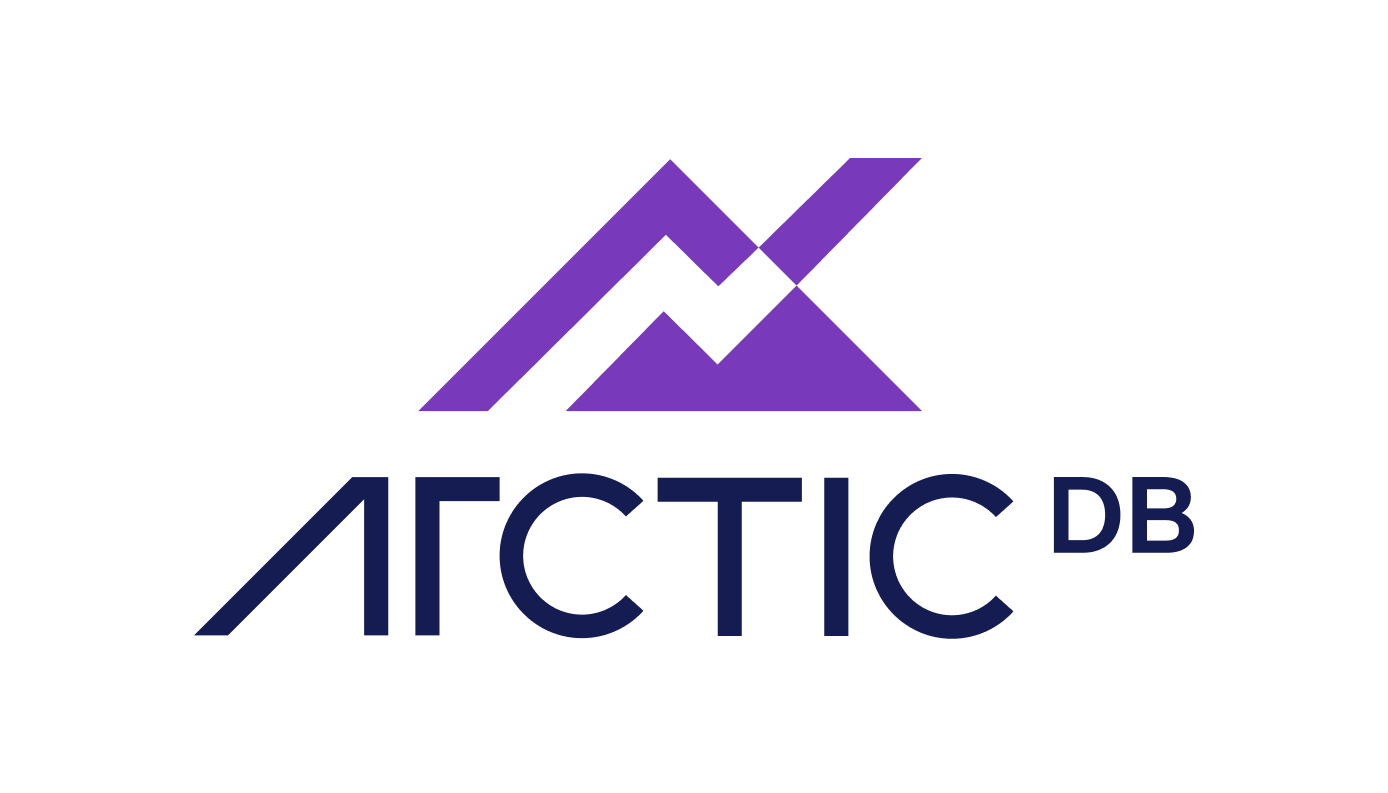
</center>

# ArcticDB Staged Data Demo

## Introduction

Staged data is data written to storage but not yet ready to be read. Use `stage` to write data in an "incomplete" state, then `finalize_staged_data` to make it readable. This enables:
* Parallel writes - multiple workers writing staged data at the same time to the same symbol, with one process able to later finalize all staged data rendering the data readable by clients.


`stage` returns a `StageResult` that lets you finalize only specific data using `finalize_stage_data(stage_results=)`. This enables:
* Faster finalization.
* Staging while finalizing - since the user specifies the data to be finalized other staging writers can continue working.
* Reliable finalize - writers can retry failed stages and then finalizers can process only successful ones.


## Demo setup

In [1]:
import pandas as pd
import numpy as np
import time
from multiprocessing import Process, Queue

from arcticdb.exceptions import NoSuchVersionException, UnsortedDataException
from arcticdb import Arctic, LibraryOptions

def make_df(rows: int, cols: int, start_date):
    index = pd.date_range(start=pd.to_datetime(start_date), periods=rows, freq="D")
    data = np.arange(1, rows * cols + 1).reshape(rows, cols, order="F")
    return pd.DataFrame(data, index=index, columns=[f"col_{i}" for i in range(cols)])

# Below library is configured to have only 2 rows per segment. This is to make the example more readable as the default is 100 000 rows per segment.    
def get_lib():
    return Arctic("lmdb://tmp/stage_tokens_demo").get_library("stage_tokens_demo", library_options=LibraryOptions(rows_per_segment=2), create_if_missing=True)

def clear_lib():
    get_lib()._nvs.version_store.clear()

sym = "sym"
clear_lib()
lib = get_lib()

In [2]:
df1 = make_df(rows=1, cols=3, start_date="2025-01-01")
df2 = make_df(rows=1, cols=3, start_date="2025-01-02")
df3 = make_df(rows=1, cols=3, start_date="2025-01-03")

In [3]:
df1

,col_0,col_1,col_2
2025-01-01,1,2,3


In [4]:
df2

,col_0,col_1,col_2
2025-01-02,1,2,3


In [5]:
df3

,col_0,col_1,col_2
2025-01-03,1,2,3


## API

> Staging can be done both sequentially and in parallel.

In [6]:
# writer1
lib.stage(sym, df1)

In [7]:
# writer2
lib.stage(sym, df2)

In [8]:
# writer3
lib.stage(sym, df3)

In [9]:
try: 
    lib.read(sym)
except NoSuchVersionException:
    print("No verioned data")

No verioned data


#### Finalizing all staged data

In [10]:
# worker finalizing all staged data - must be called after all staging workers have finished.
lib.finalize_staged_data(sym)

VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=0, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1759235711434788266)

In [11]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,2,3
2025-01-02,1,2,3
2025-01-03,1,2,3


In [12]:
clear_lib()

#### Finalizing only some data: `stage` returns a `StageResult` which can be used to control which segments to finalize

In [13]:
# worker4
stage_result_df1 = lib.stage(sym, df1)

In [14]:
# worker5
stage_result_df2 = lib.stage(sym, df2)

In [15]:
# worker6
stage_result_df3 = lib.stage(sym, df3)

In [16]:
# worker finalizing only some data - only corresponding stagers (worker4 and worker6) are required to have finished before running this finalize. worker5 and any other worker may continue staging while this runs.
lib.finalize_staged_data(sym, stage_results=[stage_result_df1, stage_result_df3])

VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=1, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1759235712142698498)

In [17]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,2,3
2025-01-03,1,2,3


##### df2 is still in the staged index, while df1 and df3 are not. Clearing all the unfinalized staged data can be done with `delete_staged_data(sym)`.

In [18]:
lib.get_staged_symbols()

['sym']

In [19]:
lib.delete_staged_data(sym)

In [20]:
lib.get_staged_symbols()

[]